In [3]:
import numpy as np
from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skewnorm


def pt_d_sample_test(data1, data2, c, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    old_expressions = np.get_printoptions()['threshold']
    np.set_printoptions(threshold=max(max_depth, old_expressions))

    if max_depth < 0:
     #  max_depth = max(1, int(np.floor(np.log2(len(data1))/0.5 )))
       max_depth = 6

    # Combine datasets and create a group identifier
    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])
    X = data[:, 0]  # assign the scaled value to X

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    discrete_values = np.unique(binary)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

 #   n_hypotheses = len(discrete_values)
    logbf = p_H0 - p_H1 # + np.log(n_hypotheses)
    np.set_printoptions(threshold=old_expressions)

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf


def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]  # counts the number of data in each interval (2 vector).


    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)    #alpha

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  # log of beta function
    else:
        logl = lmbeta(n_j[0] + a_j, n_j[1] + a_j, n_j[2] + a_j, n_j[3] + a_j) - lmbeta(a_j, a_j, a_j, a_j)

    if isinstance(low, (int, float)):
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions


    return logl + np.sum(likelihoods)


def lmbeta(*args):
    return np.sum(gammaln(args)) - gammaln(np.sum(args))


def is_discrete(X):
    return np.all(np.isin(X, np.arange(11)))  # evaluates to TRUE only if every element of X lies within the specified range of 0 to 10.

'''
def scale(data):
    return (data - np.mean(data)) / np.std(data)      #standardize
'''


def scale(data):
    median = np.median(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    return (data - median) / iqr



In [ ]:
import numpy as np
from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def pt_d_sample_test(data1, data2, c, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    if max_depth < 0:
 #     max_depth = max(1, int(np.floor(np.log2(len(data1))/2 )))
       max_depth = 7

    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])   #with two columns
    X = data[:, 0]  # assign the first column to X
    discrete_values = np.unique(binary)    #[0,1]

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

    logbf = p_H0 - p_H1

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf

def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]   #counts the number of data in each interval


    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)    #alpha

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  #natural log of beta function
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions


    return logl + np.sum(likelihoods)

def scale(data):
    return (data - np.mean(data)) / np.std(data)      #standardize

# **Null Case**

Sample sizes: 100%|██████████| 5/5 [08:41<00:00, 104.23s/it]


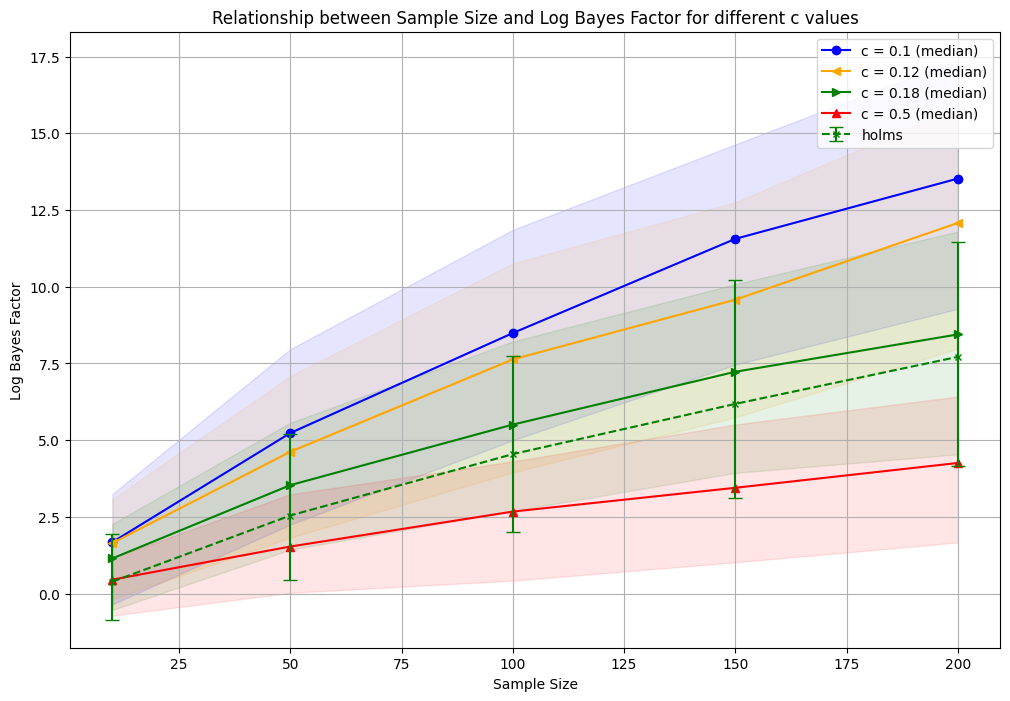

In [4]:
def calculate_bayes_factors(sample_sizes, rep, c):
    size = len(sample_sizes)
    bfmatrix = np.empty((size, rep))

    for i in tqdm(range(size), desc="Sample sizes"):
        for j in range(rep):
            data1 = np.random.normal(size=sample_sizes[i])
            data2 = np.random.normal(size=sample_sizes[i])
            bfmatrix[i, j] = pt_d_sample_test(data1, data2, c=c, log_BF=True)

    row_percentiles = np.percentile(bfmatrix, [16, 50, 84], axis=1)
    return bfmatrix, row_percentiles

sample_sizes = [10, 50, 100, 150, 200]
rep = 500

bfmatrix_c_0_1, bf_percentiles_c_0_1 = calculate_bayes_factors(sample_sizes, rep, c=0.1)
bfmatrix_c_0_12, bf_percentiles_c_0_12 = calculate_bayes_factors(sample_sizes, rep, c=0.12)
bfmatrix_c_0_18, bf_percentiles_c_0_18 = calculate_bayes_factors(sample_sizes, rep, c=0.18)
bfmatrix_c_0_5, bf_percentiles_c_0_5 = calculate_bayes_factors(sample_sizes, rep, c=0.5)

#additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [0.3896103896103895, 2.545454545454545, 4.545454545454545, 6.181818181818181, 7.7142857142857135]
additional_upper_bounds = [1.93, 5.195, 7.747, 10.229, 11.448]
additional_lower_bounds = [-0.85, 0.45, 2, 3.1, 4.16]

df_additional = pd.DataFrame({
    'SampleSize': sample_sizes,
    'MeanRowValue': additional_row_means,
    'UpperBound': additional_upper_bounds,
    'LowerBound': additional_lower_bounds
})

plt.figure(figsize=(12, 8))

plt.plot(sample_sizes, bf_percentiles_c_0_1[1], label='c = 0.1 (median)', marker='o', color='blue')
plt.fill_between(sample_sizes, bf_percentiles_c_0_1[0], bf_percentiles_c_0_1[2], color='blue', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_0_12[1], label='c = 0.12 (median)', marker='<', color='orange')
plt.fill_between(sample_sizes, bf_percentiles_c_0_12[0], bf_percentiles_c_0_12[2], color='orange', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_0_18[1], label='c = 0.18 (median)', marker='>', color='green')
plt.fill_between(sample_sizes, bf_percentiles_c_0_18[0], bf_percentiles_c_0_18[2], color='green', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_0_5[1], label='c = 0.5 (median)', marker='^', color='red')
plt.fill_between(sample_sizes, bf_percentiles_c_0_5[0], bf_percentiles_c_0_5[2], color='red', alpha=0.1)

# Holmes
plt.errorbar(df_additional['SampleSize'], df_additional['MeanRowValue'],
             yerr=[df_additional['MeanRowValue'] - df_additional['LowerBound'],
                   df_additional['UpperBound'] - df_additional['MeanRowValue']],
             fmt='x', color='green', linestyle='--', markersize=5, label='holms', capsize=5)

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')
plt.title('Relationship between Sample Size and Log Bayes Factor for different c values')
plt.legend()
plt.grid(True)
plt.show()

# **Mean Shift Case**

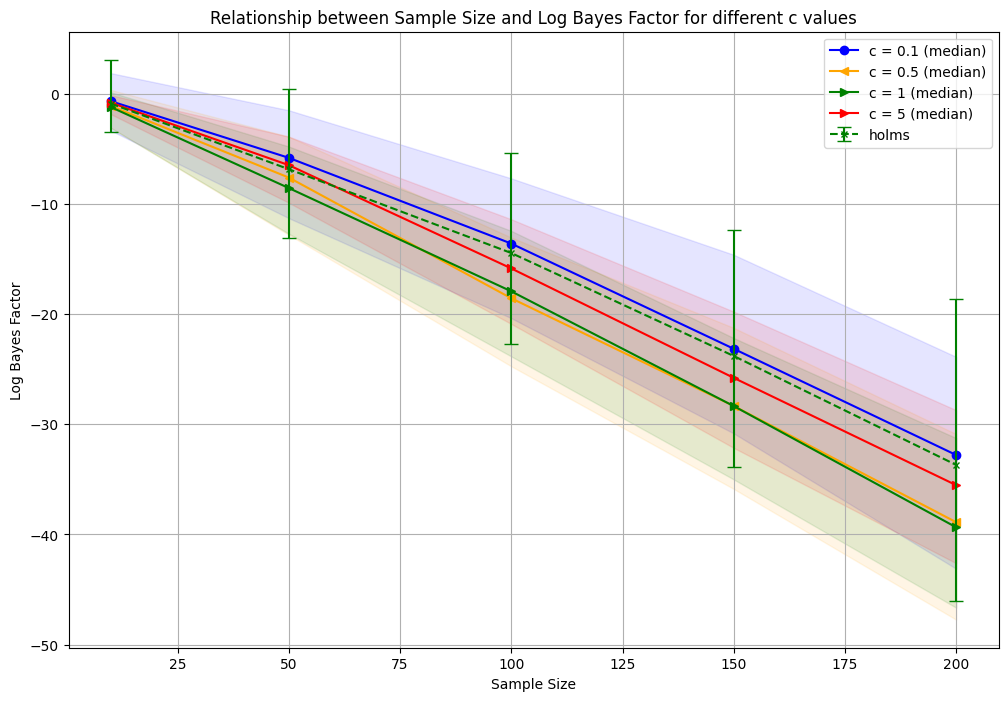

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_bayes_factors(sample_sizes, rep, c):
    size = len(sample_sizes)
    bfmatrix = np.empty((size, rep))

    for i in range(size):
        for j in range(rep):
            data1 = np.random.normal(loc=0, scale=1,size=sample_sizes[i])
            data2 = np.random.normal(loc=1, scale=1,size=sample_sizes[i])
            bfmatrix[i, j] = pt_d_sample_test(data1, data2, c=c, log_BF=True)

    row_percentiles = np.percentile(bfmatrix, [16, 50, 84], axis=1)
    return bfmatrix, row_percentiles

sample_sizes = [10, 50, 100, 150, 200]
rep = 500

bfmatrix_c_0_1, bf_percentiles_c_0_1 = calculate_bayes_factors(sample_sizes, rep, c=0.1)
bfmatrix_c_0_12, bf_percentiles_c_0_5 = calculate_bayes_factors(sample_sizes, rep, c=0.5)
bfmatrix_c_0_18, bf_percentiles_c_1 = calculate_bayes_factors(sample_sizes, rep, c=1)
bfmatrix_c_0_5, bf_percentiles_c_5 = calculate_bayes_factors(sample_sizes, rep, c=5)

additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [-0.8899663720966604, -6.846797528740124, -14.455306170329235, -23.803081254398997, -33.69515914600766]
additional_upper_bounds = [3.09, 0.45, -5.34, -12.38, -18.63]
additional_lower_bounds = [-3.499, -13.068, -22.727, -33.8636, -46.022]

df_additional = pd.DataFrame({
    'SampleSize': additional_sample_sizes,
    'MeanRowValue': additional_row_means,
    'UpperBound': additional_upper_bounds,
    'LowerBound': additional_lower_bounds
})

plt.figure(figsize=(12, 8))


plt.plot(sample_sizes, bf_percentiles_c_0_1[1], label='c = 0.1 (median)', marker='o', color='blue')
plt.fill_between(sample_sizes, bf_percentiles_c_0_1[0], bf_percentiles_c_0_1[2], color='blue', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_0_5[1], label='c = 0.5 (median)', marker='<', color='orange')
plt.fill_between(sample_sizes, bf_percentiles_c_0_5[0], bf_percentiles_c_0_5[2], color='orange', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_1[1], label='c = 1 (median)', marker='>', color='green')
plt.fill_between(sample_sizes, bf_percentiles_c_1[0], bf_percentiles_c_1[2], color='green', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_5[1], label='c = 5 (median)', marker='>', color='red')
plt.fill_between(sample_sizes, bf_percentiles_c_5[0], bf_percentiles_c_5[2], color='red', alpha=0.1)

# Plot additional data with error bars
plt.errorbar(df_additional['SampleSize'], df_additional['MeanRowValue'],
             yerr=[df_additional['MeanRowValue'] - df_additional['LowerBound'],
                   df_additional['UpperBound'] - df_additional['MeanRowValue']],
             fmt='x', color='green', linestyle='--', markersize=5, label='holms', capsize=5)

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')
plt.title('Relationship between Sample Size and Log Bayes Factor for different c values')
plt.legend()
plt.grid(True)
plt.show()


Sample sizes: 100%|██████████| 5/5 [03:27<00:00, 41.41s/it]


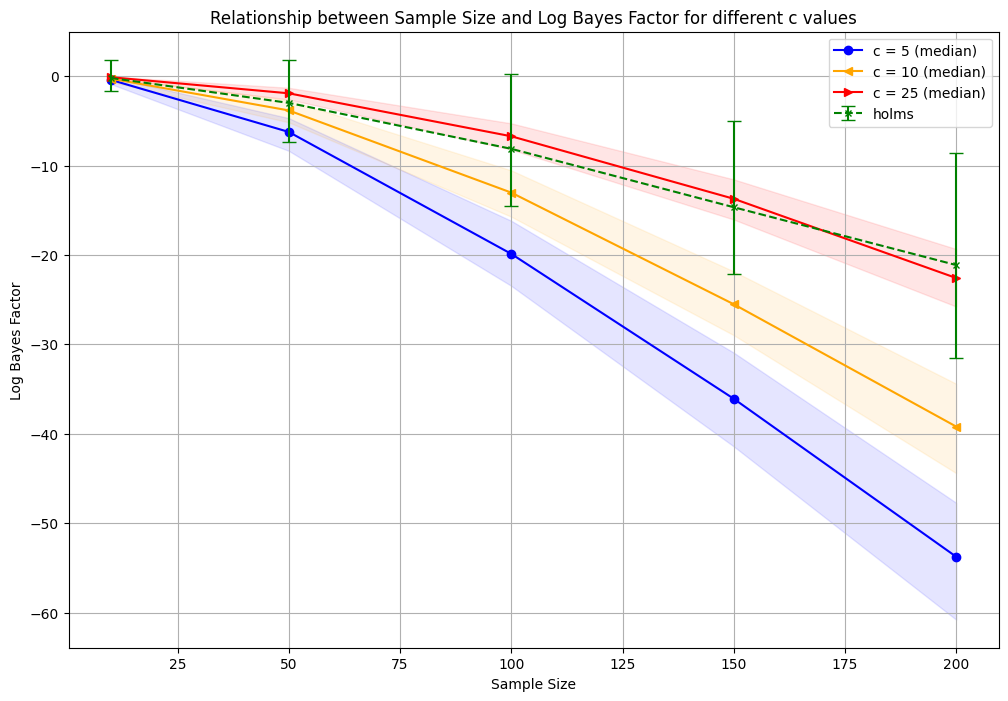

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_bayes_factors(sample_sizes, rep, c):
    size = len(sample_sizes)
    bfmatrix = np.empty((size, rep))

    for i in tqdm(range(size), desc="Sample sizes"):
        for j in range(rep):
            data1 = np.random.normal(loc=0, scale=1,size=sample_sizes[i])
            data2 = np.random.normal(loc=0, scale=4,size=sample_sizes[i])
            bfmatrix[i, j] = pt_d_sample_test(data1, data2, c=c, log_BF=True)

    row_percentiles = np.percentile(bfmatrix, [16, 50, 84], axis=1)
    return bfmatrix, row_percentiles

sample_sizes = [10, 50, 100, 150, 200]
rep = 500

bfmatrix_c_0_1, bf_percentiles_c_5 = calculate_bayes_factors(sample_sizes, rep, c=5)
bfmatrix_c_0_12, bf_percentiles_c_10 = calculate_bayes_factors(sample_sizes, rep, c=10)
bfmatrix_c_0_18, bf_percentiles_c_25 = calculate_bayes_factors(sample_sizes, rep, c=25)

additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [-0.21315789473684355, -2.9991228070175477, -8.132456140350886, -14.665350877192992, -21.130701754385974]
additional_upper_bounds = [1.81, 1.83, 0.22, -5, -8.56]
additional_lower_bounds = [-1.72, -7.42, -14.544, -22.12, -31.51]

df_additional = pd.DataFrame({
    'SampleSize': additional_sample_sizes,
    'MeanRowValue': additional_row_means,
    'UpperBound': additional_upper_bounds,
    'LowerBound': additional_lower_bounds
})

plt.figure(figsize=(12, 8))


plt.plot(sample_sizes, bf_percentiles_c_5[1], label='c = 5 (median)', marker='o', color='blue')
plt.fill_between(sample_sizes, bf_percentiles_c_5[0], bf_percentiles_c_5[2], color='blue', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_10[1], label='c = 10 (median)', marker='<', color='orange')
plt.fill_between(sample_sizes, bf_percentiles_c_10[0], bf_percentiles_c_10[2], color='orange', alpha=0.1)

plt.plot(sample_sizes, bf_percentiles_c_25[1], label='c = 25 (median)', marker='>', color='red')
plt.fill_between(sample_sizes, bf_percentiles_c_25[0], bf_percentiles_c_25[2], color='red', alpha=0.1)

# Plot additional data with error bars
plt.errorbar(df_additional['SampleSize'], df_additional['MeanRowValue'],
             yerr=[df_additional['MeanRowValue'] - df_additional['LowerBound'],
                   df_additional['UpperBound'] - df_additional['MeanRowValue']],
             fmt='x', color='green', linestyle='--', markersize=5, label='holms', capsize=5)

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')
plt.title('Relationship between Sample Size and Log Bayes Factor for different c values')
plt.legend()
plt.grid(True)
plt.show()
